# Projeto Final: Sistema de Manutenção Preditiva Industrial

- **Bootcamp:** Ciência de Dados e IA
- **Autor:** João Victor Winderfeld Bussolotto
- **Data:** 28 de Agosto de 2025

## 1. Contextualização

Este projeto tem como objetivo o desenvolvimento de um sistema inteligente de manutenção preditiva para uma empresa do setor industrial. Utilizando um conjunto de dados coletados por sensores IoT em diversas máquinas, o sistema deverá ser capaz de identificar e classificar diferentes tipos de falhas que possam ocorrer.

O resultado esperado é um modelo que, a partir de novas medições, consiga prever a classe do defeito e a probabilidade associada, além de extrair insights valiosos sobre a operação das máquinas.

---

In [ ]:
# Célula de Configuração

# 1. Importação de bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# 2. Importação de bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Configurações de visualização
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# 4. Importação de bibliotecas para Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# 5. Ignorar avisos (warnings) para manter o notebook mais limpo
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento e Inspeção Inicial dos Dados

Nesta etapa, vamos carregar o conjunto de dados de treinamento (`Bootcamp_train.csv`) e realizar uma inspeção inicial para entender sua estrutura, tipos de dados e as primeiras linhas.

In [ ]:
# Caminho para o arquivo no ambiente do Colab
file_path = 'bootcamp_train.csv'

# Tentar carregar o dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
    print("Por favor, faça o upload do arquivo para o ambiente do Colab.")

Dataset carregado com sucesso!


 **Valores Ausentes:** Foi confirmada a presença de dados faltantes em várias colunas de sensores, como `temperatura_ar`, `torque` e `desgaste_da_ferramenta`. Isso exigirá uma estratégia de tratamento (imputação) antes da modelagem.

 **Inconsistência nos Rótulos:** As colunas alvo, que indicam os tipos de falha, apresentavam uma mistura de valores (`'Não'`, `False`, etc.) e tipos de dados (`object`, `bool`).

 **Dados inconsistentes**: A documentação mostra temperaturas em Kelvin, no entanto, percebe-se valores negativos para `temperatura_ar` e `temperatura_processo`

In [ ]:
# Calcular a contagem de valores nulos por coluna
null_counts = df.isnull().sum()

# Calcular o percentual de valores nulos por coluna
null_percentages = (df.isnull().sum() / len(df)) * 100

# Criar um DataFrame para exibir os resultados de forma organizada
quality_report = pd.DataFrame({
    'contagem_nulos': null_counts,
    'percentual_nulos': null_percentages
})

# Exibir apenas as colunas que têm valores nulos, ordenadas da maior para a menor
print("Relatório de Qualidade de Dados - Valores Ausentes:")
display(quality_report[quality_report['contagem_nulos'] > 0].sort_values(by='percentual_nulos', ascending=False))

Relatório de Qualidade de Dados - Valores Ausentes:


,contagem_nulos,percentual_nulos
desgaste_da_ferramenta,952,2.699943
velocidade_rotacional,751,2.129892
torque,623,1.766875
temperatura_ar,616,1.747022
temperatura_processo,599,1.698809


### Insights sobre Dados Ausentes

A análise quantitativa de valores nulos revelou o seguinte:

* **Percentuais Baixos:** Nenhuma coluna apresenta um percentual de dados faltantes drasticamente alto (todos estão abaixo de 3% ). Isso é uma boa notícia, pois sugere que não precisaremos descartar nenhuma feature por falta de dados.
* **Estratégia de Tratamento:** Dado o baixo percentual de ausência, uma estratégia de **imputação** (preenchimento dos valores) é a mais indicada. Poderemos usar a média ou a mediana da respectiva coluna para preencher os valores faltantes. Descartar as linhas, embora possível, resultaria na perda de quase 1000 amostras, o que não é ideal.

In [ ]:
# --- Análise Consolidada das Temperaturas ---

# 1. Investigar anomalias em 'temperatura_ar'
anomalous_air_temp = df[df['temperatura_ar'] <= 0]
num_anomalies_air = len(anomalous_air_temp)

print(f"Número de registros com 'temperatura_ar' anômala (<= 0 Kelvin): {num_anomalies_air}")
if num_anomalies_air > 0:
    print("Exemplos de anomalias em 'temperatura_ar':")
    display(anomalous_air_temp.head())

print("\n" + "="*50 + "\n") # Separador

# 2. Investigar anomalias em 'temperatura_processo'
anomalous_proc_temp = df[df['temperatura_processo'] <= 0]
num_anomalies_proc = len(anomalous_proc_temp)

print(f"Número de registros com 'temperatura_processo' anômala (<= 0 Kelvin): {num_anomalies_proc}")
if num_anomalies_proc > 0:
    print("Exemplos de anomalias em 'temperatura_processo':")
    display(anomalous_proc_temp.head())

print("\n" + "="*50 + "\n") # Separador

# 3. Verificar a consistência física (processo > ar)
#    Analisamos apenas no subconjunto de dados onde ambas as temperaturas são plausíveis (positivas)
df_valid_temps = df[(df['temperatura_ar'] > 0) & (df['temperatura_processo'] > 0)]
inconsistent_temps = df_valid_temps[df_valid_temps['temperatura_processo'] < df_valid_temps['temperatura_ar']]
num_inconsistent = len(inconsistent_temps)

print(f"Número de registros onde Temp. Processo < Temp. Ar: {num_inconsistent}")
if num_inconsistent > 0:
    print("\nExemplos de registros com temperaturas inconsistentes:")
    display(inconsistent_temps.head())

Número de registros com 'temperatura_ar' anômala (<= 0 Kelvin): 3132
Exemplos de anomalias em 'temperatura_ar':


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não
6,6,M23689,M,-36.0,308.8,90.0,1469.0,44.1,150.0,não,False,False,Não,False,não
23,23,M23839,M,-36.0,307.5,90.0,1332.0,51.1,121.0,Não,False,False,Não,False,não
75,75,L56058,L,-36.0,309.2,90.0,1802.0,26.9,83.0,Não,False,False,não,False,Não
83,83,M16328,M,-36.0,309.8,90.0,1419.0,44.9,115.0,Não,False,False,Não,False,Não




Número de registros com 'temperatura_processo' anômala (<= 0 Kelvin): 2939
Exemplos de anomalias em 'temperatura_processo':


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
48,48,L49193,L,298.6,-38.0,90.0,1485.0,42.9,38.0,não,False,False,Não,False,Não
77,77,M23226,M,298.9,-38.0,90.0,1836.0,22.8,18.0,não,False,False,Não,False,Não
105,105,L52996,L,301.3,-38.0,90.0,1582.0,35.6,202.0,não,False,False,Não,False,não
110,110,L56828,L,299.1,-38.0,90.0,1416.0,41.2,185.0,Não,False,False,não,False,Não
114,114,L48925,L,298.5,-38.0,90.0,1624.0,29.8,160.0,Não,False,False,Não,False,não




Número de registros onde Temp. Processo < Temp. Ar: 0


In [ ]:
print("Distribuição dos valores na coluna 'temperatura_ar':")
display(anomalous_air_temp['temperatura_ar'].value_counts().sort_index())

print("\nDistribuição dos valores na coluna 'temperatura_processo':")
display(anomalous_proc_temp['temperatura_processo'].value_counts().sort_index())

Distribuição dos valores na coluna 'temperatura_ar':


,count
temperatura_ar,
-36.0,3132



Distribuição dos valores na coluna 'temperatura_processo':


,count
temperatura_processo,
-38.0,2939


### Insights sobre Anomalias de Temperatura

A análise consolidada das colunas `temperatura_ar` e `temperatura_processo` revelou os seguintes pontos críticos:

* **Anomalias em `temperatura_ar`:** Foram encontrados **3132 registros** com valores anômalos (<= 0 Kelvin). A consistência do valor `-36.0` sugere um código de erro sistemático do sensor.
* **Anomalias em `temperatura_processo`:** De forma similar, foram encontrados **2939 registros** com valores anômalos. O valor predominante de `-38.0` indica um segundo código de erro específico para este sensor.
* **Inconsistência Física:** Nos dados onde ambas as temperaturas são positivas, **não foi encontrado nenhum caso** onde a temperatura do processo fosse menor que a do ar. Isso nos dá confiança na qualidade dos dados quando eles não estão em estado de erro.
* **Estratégia de Tratamento Unificada:** A estratégia será tratar todos os valores de temperatura identificados como anômalos (negativos ou zero) como dados ausentes (`NaN`). Eles serão então preenchidos (imputados) junto com os outros valores nulos do dataset, garantindo a consistência e integridade dos dados antes da modelagem.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colunas de falha para análise visual


def plot_fault_distributions(df):
    """
    Plota a distribuição de valores para as colunas de falha especificadas.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        fault_cols (list): Uma lista de nomes de colunas de falha para plotar.
    """
    fault_cols = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
    ]
    n_cols = 2
    n_rows = (len(fault_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(15, n_rows * 5))

    for i, col in enumerate(fault_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df, x=col, palette='viridis')
        plt.title(f'Distribuição de Valores em "{col}"')
        plt.xlabel(col)
        plt.ylabel('Contagem')
        plt.xticks(rotation=45, ha='right') # Rotacionar rótulos para melhor leitura

    plt.tight_layout()
    plt.show()


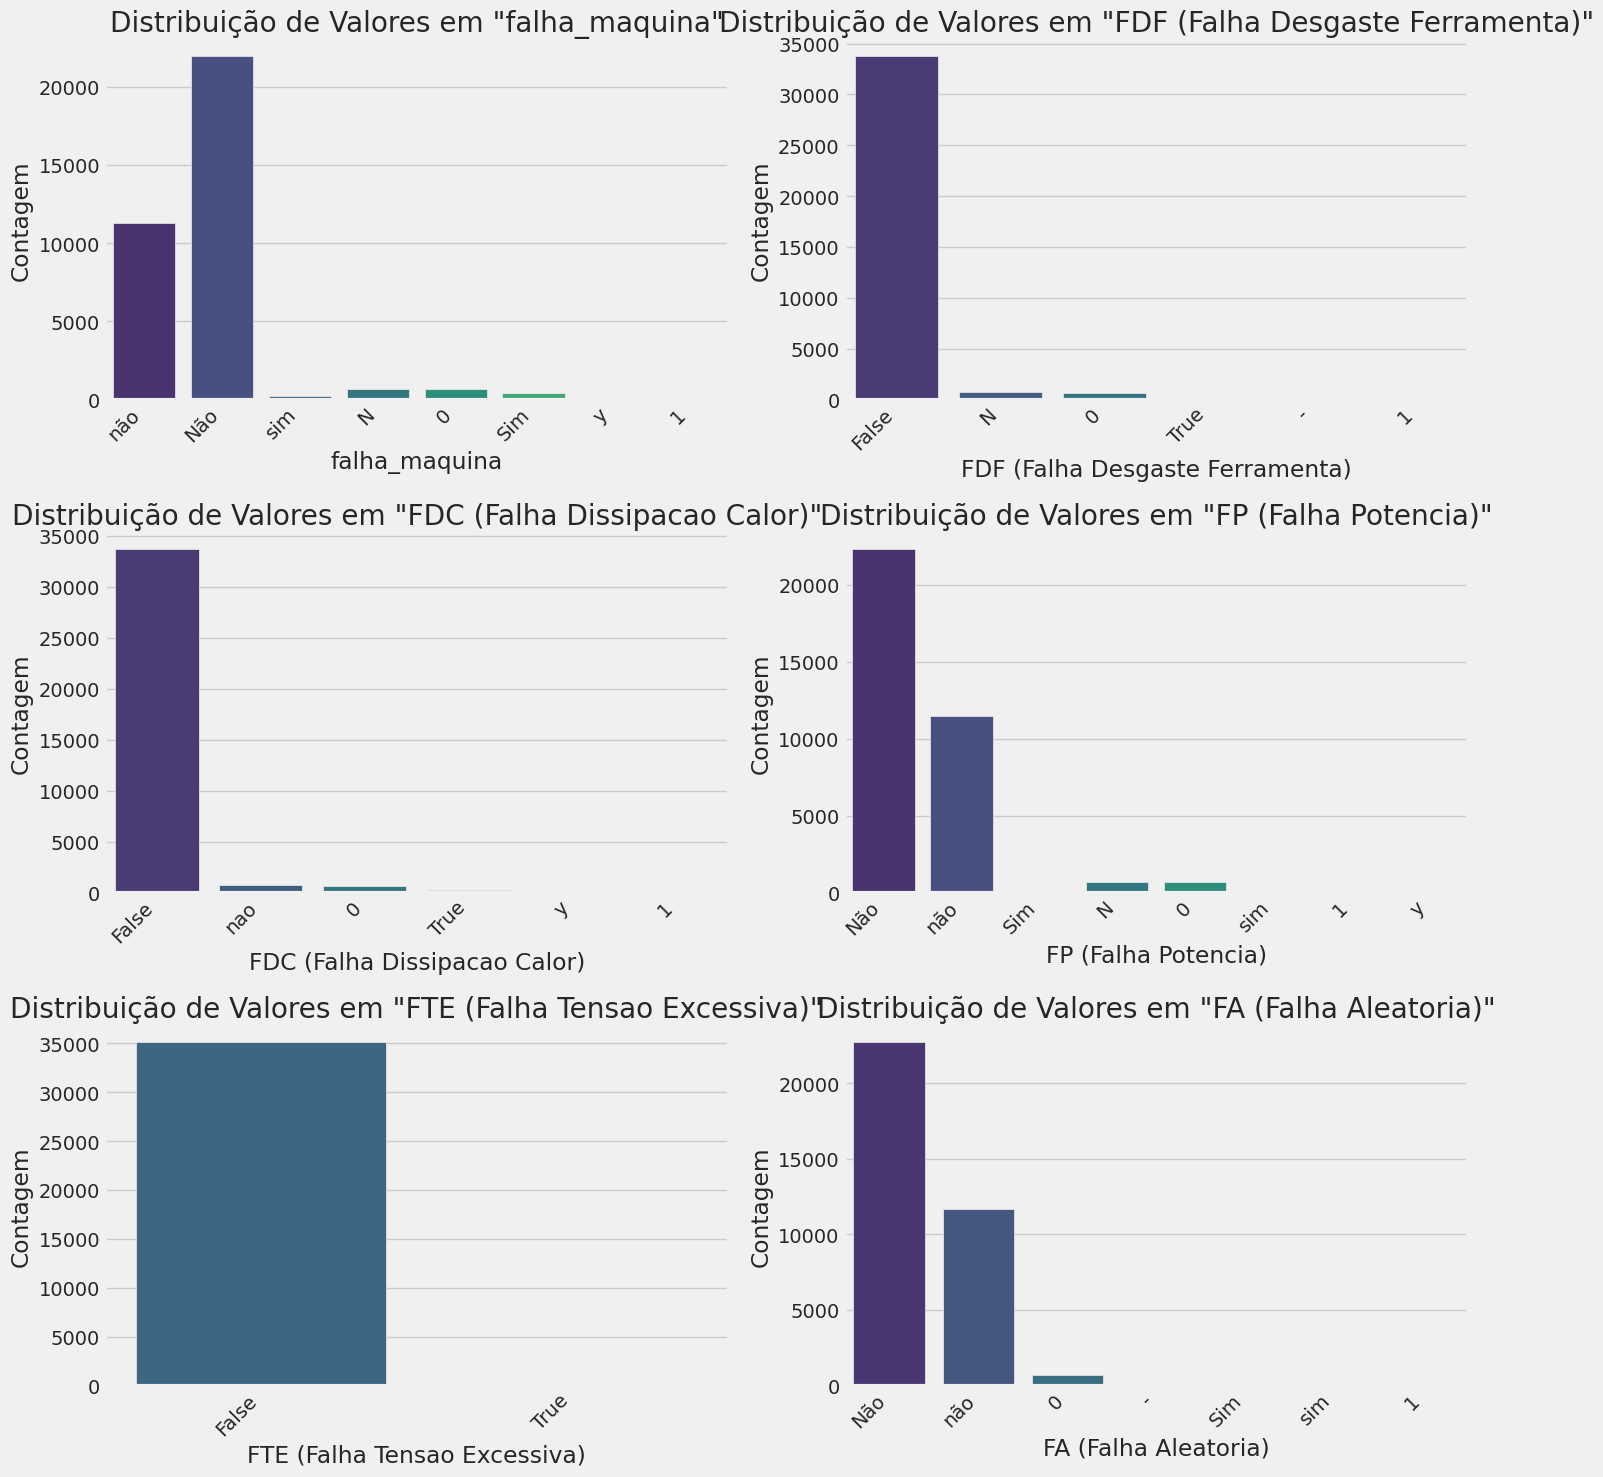

In [ ]:
plot_fault_distributions(df)

In [ ]:
# Mapeamento para padronizar os valores das colunas de falha
# Assumindo que 'Não', 'False', 'n', 0 correspondem a 'Não'
# Assumindo que 'Sim', 'True', 'y', 1 correspondem a 'Sim'
# 'N' e 'nao' parecem ser grafia inconsistente de 'Não' ou 'nao', vamos mapear para 'Não'

standardization_map = {
    'não': 'Não',
    'Não': 'Não',
    'False': 'Não',
    'N': 'Não',
    'nao': 'Não', # Adicionado com base na análise gráfica anterior
    'sim': 'Sim',
    'Sim': 'Sim',
    'True': 'Sim',
    'y': 'Sim',
    'Y': 'Sim', # Adicionado caso exista
    0: 'Não', # Adicionado caso existam valores numéricos 0
    1: 'Sim', # Adicionado caso existam valores numéricos 1,
    None: None
}

# Colunas de falha a serem padronizadas
fault_columns_to_standardize = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FA (Falha Aleatoria)',
    'FTE (Falha Tensao Excessiva)' # Incluir a coluna booleana que pode ter outras representações
]

print("Padronizando valores nas colunas de falha...")

for col in fault_columns_to_standardize:
    # Aplicar o mapeamento, tratando quaisquer valores que não estejam no mapa como NaN (ou manter como estão, dependendo da estratégia)
    # Usar .get(value, value) para manter valores que não estão no mapa (se houver) ou usar .map() e lidar com NaNs posteriormente
    # df[col] = df[col].map(standardization_map).fillna(df[col]) # Opção 1: Mapear e manter NaNs originais
    # df[col] = df[col].apply(lambda x: standardization_map.get(x, x)) # Opção 2: Usar apply com get para manter valores não mapeados

    # Vamos tentar um mapeamento direto, convertendo para string primeiro para garantir que as chaves do dicionário funcionem
    df[col] = df[col].astype(str).map(standardization_map)

print("Padronização concluída. Verificando os valores únicos após a padronização:")

# Verificar os valores únicos após a padronização
for col in fault_columns_to_standardize:
    print(f"Coluna '{col}': {df[col].unique()}")

Padronizando valores nas colunas de falha...
Padronização concluída. Verificando os valores únicos após a padronização:
Coluna 'falha_maquina': ['Não' 'Sim' nan]
Coluna 'FDF (Falha Desgaste Ferramenta)': ['Não' nan 'Sim']
Coluna 'FDC (Falha Dissipacao Calor)': ['Não' nan 'Sim']
Coluna 'FP (Falha Potencia)': ['Não' 'Sim' nan]
Coluna 'FA (Falha Aleatoria)': ['Não' nan 'Sim']
Coluna 'FTE (Falha Tensao Excessiva)': ['Não' 'Sim']


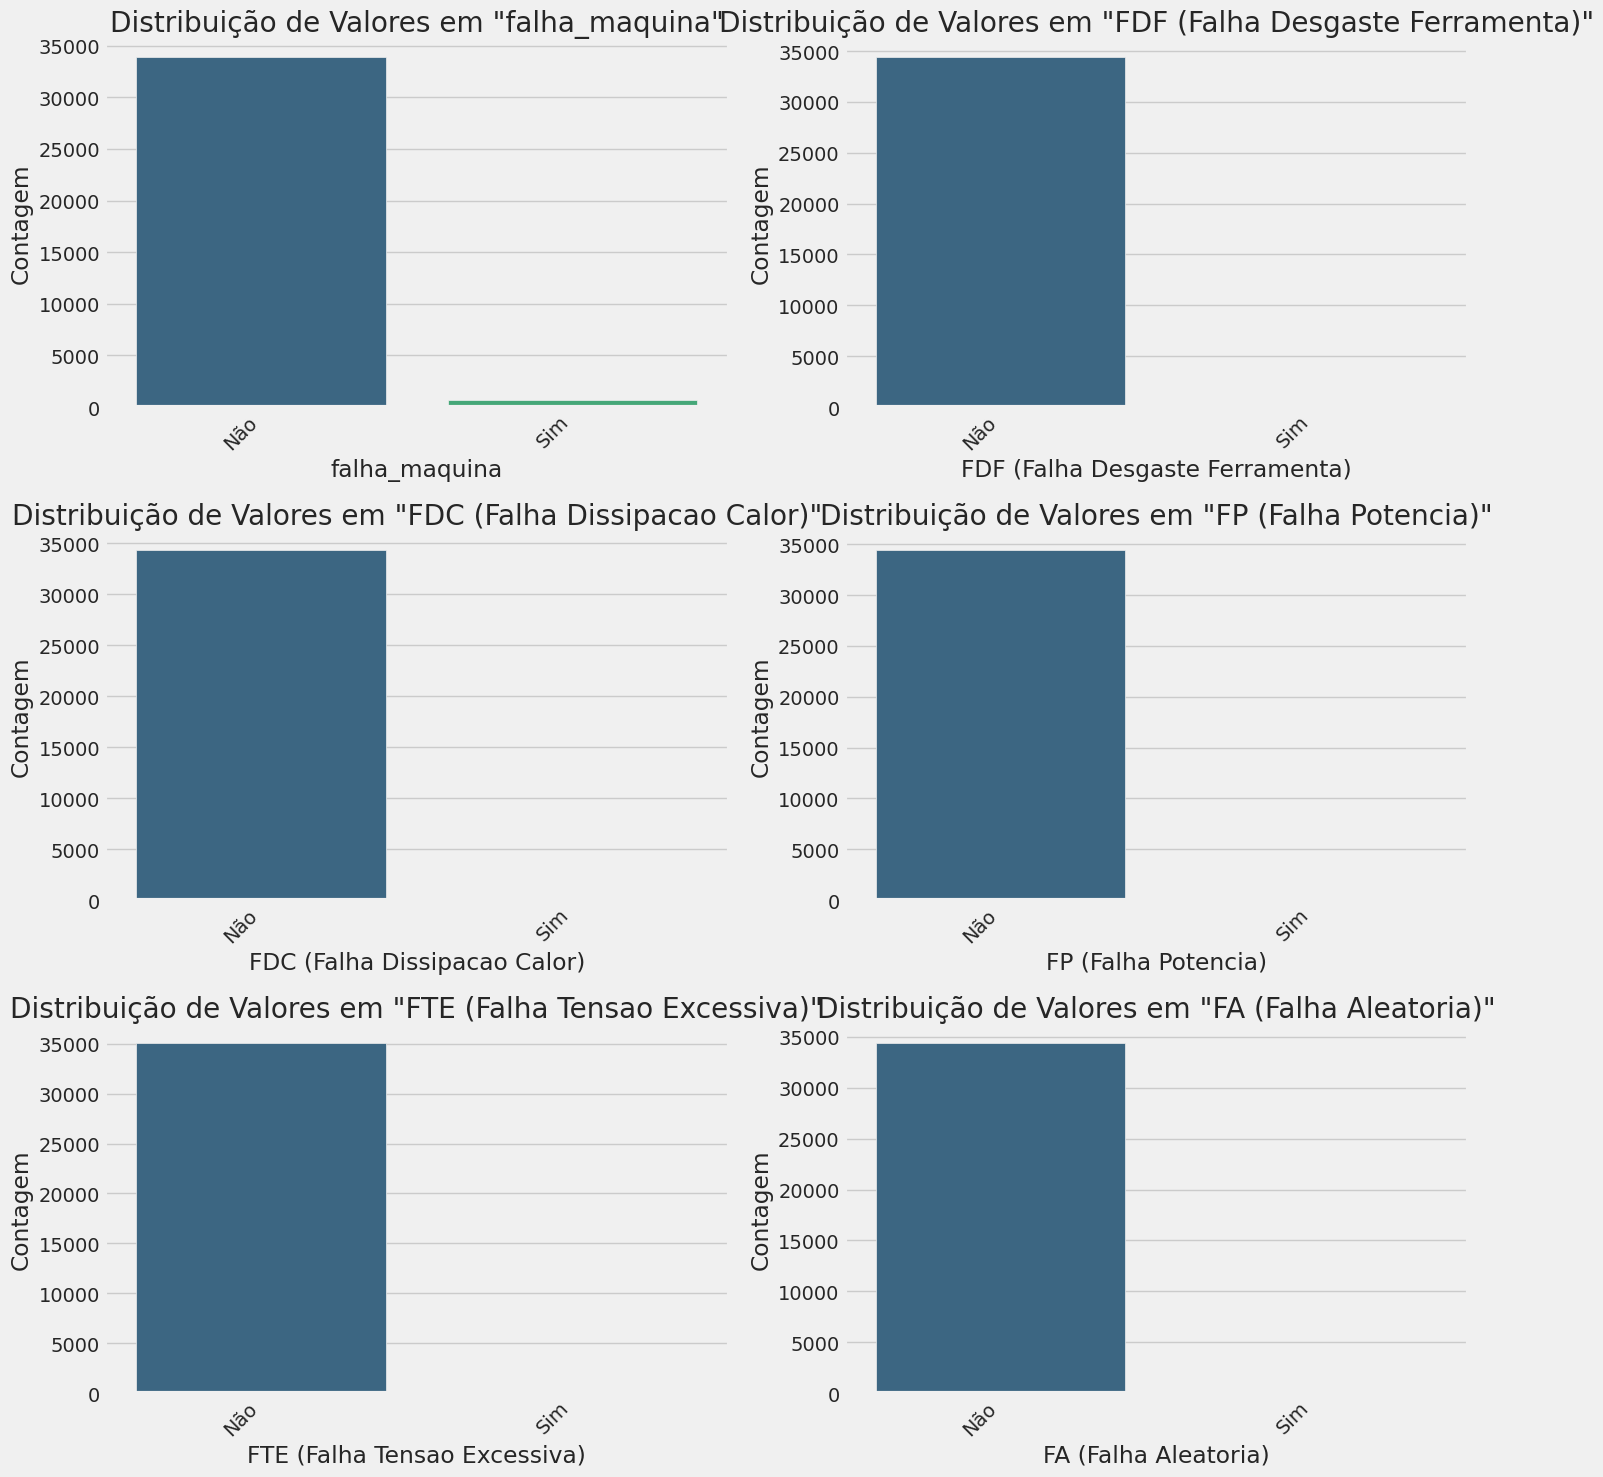

In [ ]:
plot_fault_distributions(df)

## 5. Análise Exploratória de Dados (EDA)
Começaremos investigando o balanceamento das classes, um ponto crucial para o projeto.

In [ ]:
# --- Célula para criar e limpar o df_clean ---

# 1. Criar uma cópia do dataframe original
df_clean = df.copy()

# 2. Renomear as colunas de falha para nomes mais curtos
rename_dict = {
    'FDF (Falha Desgaste Ferramenta)': 'fdf',
    'FDC (Falha Dissipacao Calor)': 'fdc',
    'FP (Falha Potencia)': 'fp',
    'FTE (Falha Tensao Excessiva)': 'fte',
    'FA (Falha Aleatoria)': 'fa',
    'falha_maquina': 'falha_maquina'
}
df_clean.rename(columns=rename_dict, inplace=True)

# 3. Padronizar todos os nomes de colunas para minúsculas
df_clean.columns = [col.lower() for col in df_clean.columns]

# 4. Unificar os valores das colunas de falha para 0 e 1
falha_cols = ['falha_maquina', 'fdf', 'fdc', 'fp', 'fte', 'fa']
map_sim_nao = {
    'não': 0, 'Não': 0, 'N': 0, False: 0,
    'sim': 1, 'Sim': 1, 'S': 1, True: 1
}

for col in falha_cols:
    df_clean[col] = df_clean[col].map(map_sim_nao)
    df_clean[col].fillna(0, inplace=True) # Trata possíveis valores não mapeados como 0
    df_clean[col] = df_clean[col].astype(int)

print("DataFrame 'df_clean' criado com sucesso e pronto para visualização!")
print("\nContagem de valores para 'falha_maquina' (0 = Sem Falha, 1 = Com Falha):")
print(df_clean['falha_maquina'].value_counts())

DataFrame 'df_clean' criado com sucesso e pronto para visualização!

Contagem de valores para 'falha_maquina' (0 = Sem Falha, 1 = Com Falha):
falha_maquina
0    34610
1      650
Name: count, dtype: int64


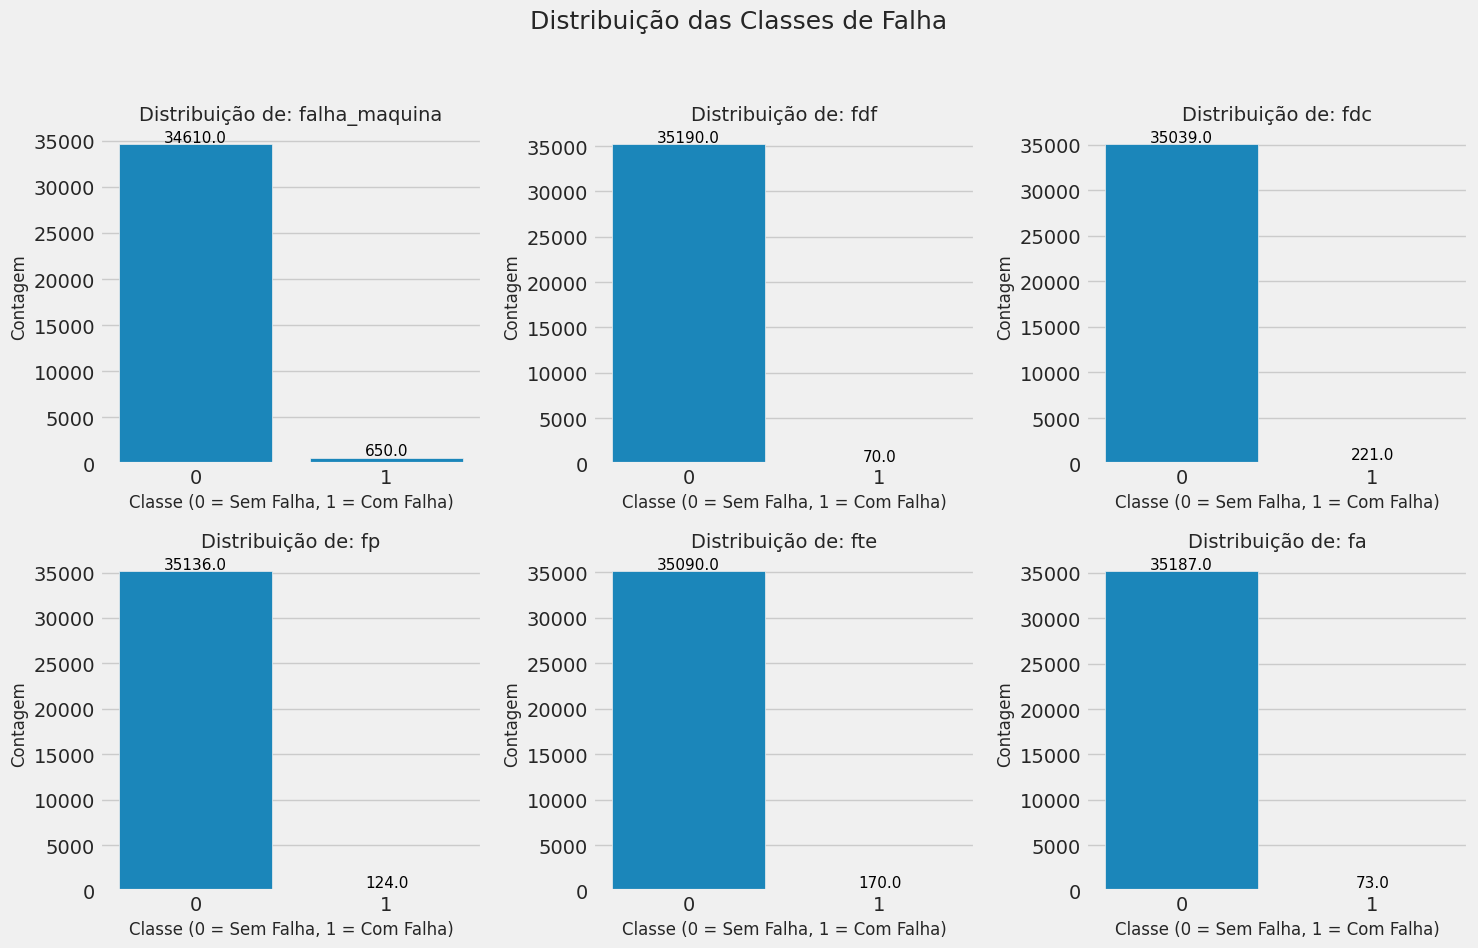

In [ ]:
# Definir o tamanho da figura para os gráficos
plt.figure(figsize=(15, 10))
plt.suptitle('Distribuição das Classes de Falha', fontsize=18)

# Colunas de falha
falha_cols = ['falha_maquina', 'fdf', 'fdc', 'fp', 'fte', 'fa']

# Loop para criar um subplot para cada tipo de falha
for i, col in enumerate(falha_cols, 1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(x=df_clean[col])
    plt.title(f'Distribuição de: {col}', fontsize=14)
    plt.xlabel('Classe (0 = Sem Falha, 1 = Com Falha)', fontsize=12)
    plt.ylabel('Contagem', fontsize=12)

    # Adicionar contagem absoluta em cima das barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:

falha_cols = ['fdf', 'fdc', 'fp', 'fte', 'fa']

# Calcular a soma das falhas por linha
df_clean['numero_de_falhas'] = df_clean[falha_cols].sum(axis=1)

# Filtrar para encontrar registros com mais de uma falha
multiple_failures = df_clean[df_clean['numero_de_falhas'] > 1]

print("Registros com múltiplas falhas:")
display(multiple_failures)

print(f"\nNúmero total de registros com múltiplas falhas: {len(multiple_failures)}")

Registros com múltiplas falhas:


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,fdf,fdc,fp,fte,fa,numero_de_falhas
989,989,L47249,L,298.9,309.0,90.0,1410.0,65.7,191.0,1,0,0,1,1,0,2
1247,1247,L51597,L,-36.0,310.4,90.0,1365.0,66.8,80.0,1,0,1,1,0,0,2
2953,2953,H35323,H,300.7,310.2,90.0,1364.0,65.3,208.0,1,1,0,1,1,0,3
3219,3219,L51563,L,-36.0,309.5,90.0,1298.0,65.5,229.0,1,0,1,0,1,0,2
3509,3509,L50791,L,301.7,310.9,90.0,1405.0,46.4,207.0,1,1,0,0,0,1,2
3645,3645,L51550,L,302.0,309.9,90.0,1308.0,57.6,197.0,1,0,1,0,1,0,2
3695,3695,L51642,L,302.7,310.5,90.0,1263.0,67.8,197.0,1,0,1,0,1,0,2
5102,5102,M20254,M,302.8,NaN,90.0,1262.0,70.5,234.0,1,0,0,1,1,0,2
5441,5441,M23786,M,297.3,308.3,90.0,1459.0,59.6,207.0,1,0,0,1,1,0,2
5486,5486,L51823,L,303.2,311.4,90.0,1324.0,54.2,228.0,1,0,1,0,1,0,2



Número total de registros com múltiplas falhas: 17


### Insights do Balanceamento de Classes

A análise visual da distribuição das variáveis alvo revelou um **severo desbalanceamento de classes**, que é a característica mais importante do nosso conjunto de dados:

* **Falhas são Eventos Raros:** Conforme esperado em um cenário de manutenção preditiva, a ocorrência de falhas (`classe 1`) é significativamente menor do que a operação normal (`classe 0`). A falha geral (`falha_maquina`) representa menos de 2% dos dados.
* **Impacto na Modelagem:** Este desbalanceamento extremo tem duas implicações diretas no projeto:
    1.  **Métricas de Avaliação:** A acurácia não é uma métrica confiável. A avaliação dos modelos deverá ser baseada em métricas como **AUC-ROC**, **Precision**, **Recall** e **F1-Score**, que são mais robustas a dados desbalanceados.
    2.  **Técnicas de Treinamento:** Para evitar que o modelo se torne enviesado e simplesmente ignore a classe minoritária (as falhas), será necessário o uso de técnicas específicas, como o balanceamento de pesos (`class_weight`) durante o treinamento do modelo.
* **Soma das Falhas:** A soma das falhas específicas (FDF, FDC, etc.) é aproximadamente igual ao total de falhas em `falha_maquina`. Isso sugere que, na maioria dos casos, uma falha é de um único tipo, o que reforça a validade da abordagem multirrótulo (um classificador binário por tipo de falha).

### 5.1. Análise Bivariada: Relação entre Features e a Ocorrência de Falhas


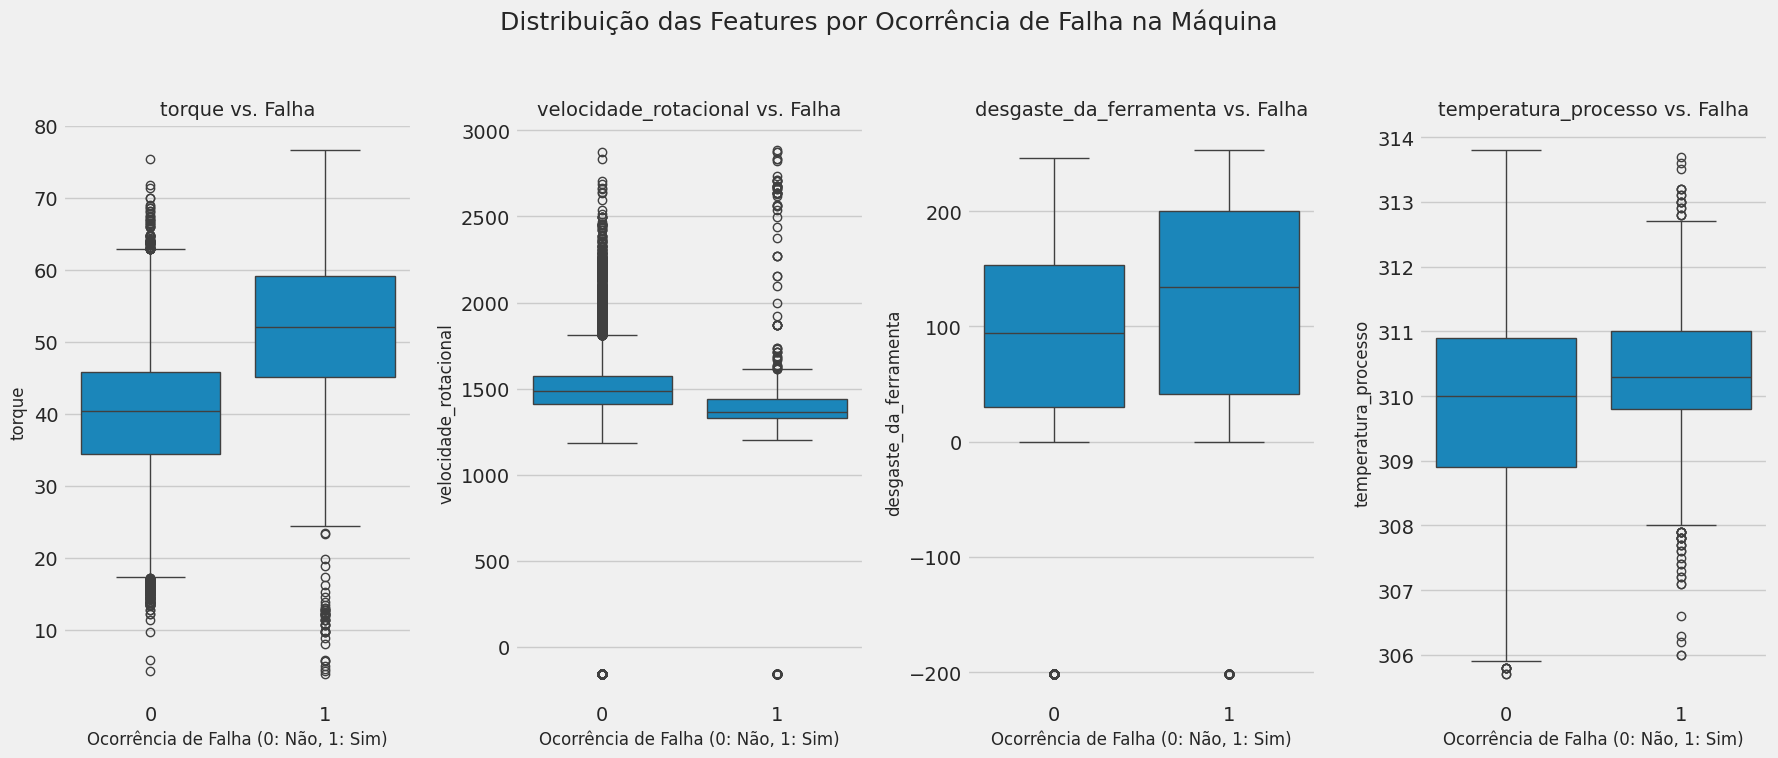

In [ ]:
# Selecionar algumas features numéricas importantes para análise
features_to_plot = ['torque', 'velocidade_rotacional', 'desgaste_da_ferramenta', 'temperatura_processo']

# Criar a figura
plt.figure(figsize=(18, 8))
plt.suptitle('Distribuição das Features por Ocorrência de Falha na Máquina', fontsize=18)

# --- CORREÇÃO ---
# Vamos primeiro criar um dataframe de plotagem limpo e completo
df_plot = df_clean.copy()

# 1. Tratar as temperaturas anômalas, convertendo-as para NaN
df_plot.loc[df_plot['temperatura_ar'] <= 0, 'temperatura_ar'] = np.nan
df_plot.loc[df_plot['temperatura_processo'] <= 0, 'temperatura_processo'] = np.nan

# 2. Definir explicitamente as colunas numéricas que precisam de imputação
cols_to_fill = ['temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

# 3. Fazer a imputação com a mediana apenas nessas colunas
for col in cols_to_fill:
    median_value = df_plot[col].median()
    df_plot[col].fillna(median_value, inplace=True)
# --- FIM DA CORREÇÃO ---


# Loop para criar um subplot para cada feature, agora usando o df_plot 100% limpo
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x='falha_maquina', y=feature, data=df_plot)
    plt.title(f'{feature} vs. Falha', fontsize=14)
    plt.xlabel('Ocorrência de Falha (0: Não, 1: Sim)', fontsize=12)
    plt.ylabel(feature, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Insights da Análise Bivariada (Boxplots)

A comparação das distribuições das features entre os casos de falha e não falha revelou padrões muito claros e preditivos:

* **Sinais Fortes de Falha:** As variáveis **`torque`** e **`velocidade_rotacional`** são os indicadores mais fortes de uma falha iminente. As falhas estão fortemente correlacionadas com um **aumento no torque** e uma **diminuição na velocidade rotacional**, o que é característico de uma máquina sob esforço excessivo.
* **Sinais Secundários:** O **`desgaste_da_ferramenta`** também é um bom indicador, com falhas ocorrendo em níveis de desgaste mais altos. A **`temperatura_processo`**, por outro lado, parece ser um preditor fraco, com distribuições muito semelhantes entre os dois grupos.
* **Nova Questão de Qualidade:** Observou-se no gráfico de `desgaste_da_ferramenta` a presença de valores negativos para a classe 0, o que é fisicamente impossível. Isso precisa ser tratado como mais um ponto de limpeza de dados.
* **Conclusão:** A hipótese de que os sensores podem prever falhas é validada. O modelo de Machine Learning terá sinais claros nos quais se basear para fazer suas previsões.

In [ ]:
neg_desgaste = df_plot[df_plot['desgaste_da_ferramenta'] < 0]
num_neg_desgaste = len(neg_desgaste)

print(f"Número de registros com 'desgaste_da_ferramenta' negativo: {num_neg_desgaste}")

Número de registros com 'desgaste_da_ferramenta' negativo: 3439


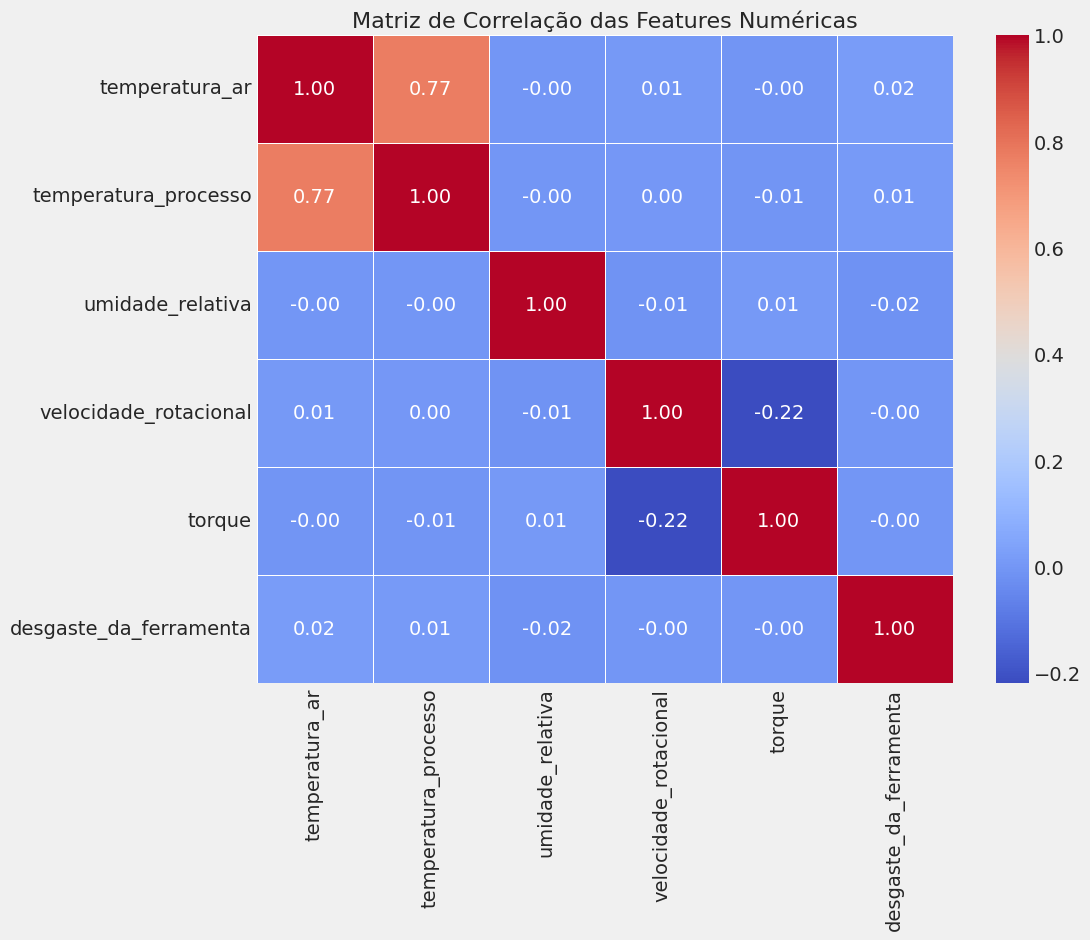

In [ ]:

# Criar uma cópia do df_plot para a análise de correlação
df_corr = df_plot.copy()

# Corrigir o desgaste negativo antes de calcular a correlação, tratando-o como 0
df_corr.loc[df_corr['desgaste_da_ferramenta'] < 0, 'desgaste_da_ferramenta'] = 0

# Selecionar apenas as colunas numéricas de features
numeric_features = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

# Calcular a matriz de correlação
correlation_matrix = df_corr[numeric_features].corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlação das Features Numéricas', fontsize=16)
plt.show()

### Insights da Matriz de Correlação

A análise de correlação entre as features numéricas nos permitiu entender a relação entre os próprios sensores:

* **Redundância de Temperatura:** Foi confirmada uma forte correlação positiva (+0.77) entre a `temperatura_ar` e a `temperatura_processo`.
* **Relação Inversa:** A correlação negativa de -0.22 entre `torque` e `velocidade_rotacional` confirma numericamente que estas duas variáveis operam de forma inversa, como observado nos boxplots.
* **Independência das Features:** A maioria das outras features, como a `umidade_relativa`, apresenta correlação próxima de zero com as demais, indicando que fornecem informações independentes.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

class TemperatureNegativeReplacer(BaseEstimator, TransformerMixin):
    """Transformer para substituir temperaturas negativas por NaN"""

    def __init__(self, temperature_columns=None):
        self.temperature_columns = temperature_columns or ['temperatura_ar', 'temperatura_processo']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.temperature_columns:
            if col in X.columns:
                mask = X[col] < 0
                X.loc[mask, col] = np.nan
                print(f"Substituídas {mask.sum()} temperaturas < 0 em {col}")
        return X

class GroupedKNNImputer(BaseEstimator, TransformerMixin):
    """KNN Imputer que funciona agrupado por uma coluna específica"""

    def __init__(self, group_column='id_produto', n_neighbors=5,
                 numeric_columns=None, exclude_columns=None):
        self.group_column = group_column
        self.n_neighbors = n_neighbors
        self.numeric_columns = numeric_columns
        self.exclude_columns = exclude_columns or ['id']
        self.scalers_ = {}
        self.imputers_ = {}

    def fit(self, X, y=None):
        X = X.copy()

        # Identificar colunas numéricas se não especificado
        if self.numeric_columns is None:
            self.numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
            # Remover colunas excluídas
            for col in self.exclude_columns:
                if col in self.numeric_columns:
                    self.numeric_columns.remove(col)
            # Remover coluna de agrupamento se for numérica
            if self.group_column in self.numeric_columns:
                self.numeric_columns.remove(self.group_column)

        print(f"Colunas numéricas para imputação: {self.numeric_columns}")

        # Treinar um modelo por grupo
        for group_value in X[self.group_column].unique():
            mask = X[self.group_column] == group_value
            X_group = X[mask][self.numeric_columns].copy()

            # Verificar se há dados suficientes
            dados_validos = X_group.dropna()
            if len(dados_validos) == 0:
                continue

            n_neighbors_ajustado = min(self.n_neighbors, len(dados_validos))

            # Treinar scaler
            scaler = StandardScaler()
            imputer = KNNImputer(n_neighbors=n_neighbors_ajustado)

            # Fit apenas com dados válidos para o scaler
            if len(dados_validos) > 0:
                scaler.fit(dados_validos)
                # Para o imputer, usamos todos os dados do grupo
                X_scaled = scaler.transform(X_group)
                imputer.fit(X_scaled)

                self.scalers_[group_value] = scaler
                self.imputers_[group_value] = imputer

        return self

    def transform(self, X):
        X = X.copy()

        for group_value in X[self.group_column].unique():
            mask = X[self.group_column] == group_value

            if group_value not in self.imputers_:
                # Se não temos modelo para este grupo, usar média global
                for col in self.numeric_columns:
                    if col in X.columns:
                        media_global = X[col].mean()
                        X.loc[mask & X[col].isnull(), col] = media_global
                continue

            X_group = X[mask][self.numeric_columns].copy()

            # Aplicar transformações
            scaler = self.scalers_[group_value]
            imputer = self.imputers_[group_value]

            # Scale
            X_scaled = scaler.transform(X_group)

            # Impute
            X_imputed_scaled = imputer.transform(X_scaled)

            # Inverse scale
            X_imputed = scaler.inverse_transform(X_imputed_scaled)

            # Atualizar valores no dataframe original
            X.loc[mask, self.numeric_columns] = X_imputed

        return X

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """Transformer para selecionar colunas específicas"""

    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns is None:
            return X
        return X[self.columns]

class SensorValidityChecker(BaseEstimator, TransformerMixin):
    """Cria feature sensor_ok baseada na validade dos dados dos sensores"""

    def __init__(self, temperature_columns=None, sensor_columns=None,
                 temp_ranges=None, create_individual_flags=False):
        """
        Parameters:
        temperature_columns: colunas de temperatura
        sensor_columns: todas as colunas de sensores para validar
        temp_ranges: dict com ranges válidos para temperaturas
        create_individual_flags: se True, cria flags individuais por sensor
        """
        self.temperature_columns = temperature_columns or ['temperatura_ar', 'temperatura_processo']
        self.sensor_columns = sensor_columns
        self.temp_ranges = temp_ranges or {
            'temperatura_ar': (-40, 60),      # Celsius
            'temperatura_processo': (0, 200)   # Celsius
        }
        self.create_individual_flags = create_individual_flags

    def fit(self, X, y=None):
        # Auto-detectar colunas de sensores se não especificado
        if self.sensor_columns is None:
            sensor_keywords = ['temperatura', 'umidade', 'velocidade', 'torque', 'desgaste']
            self.sensor_columns = []
            for col in X.columns:
                if any(keyword in col.lower() for keyword in sensor_keywords):
                    self.sensor_columns.append(col)

        print(f"Colunas de sensores identificadas: {self.sensor_columns}")
        return self

    def transform(self, X):
        X = X.copy()

        # Inicializar sensor_ok como True
        X['sensor_ok'] = True

        # 1. Verificar temperaturas negativas
        for col in self.temperature_columns:
            if col in X.columns:
                invalid_temp = X[col] < 0
                X.loc[invalid_temp, 'sensor_ok'] = False

                if self.create_individual_flags:
                    X[f'{col}_sensor_ok'] = ~invalid_temp

        # 2. Verificar ranges de temperatura
        for col, (min_val, max_val) in self.temp_ranges.items():
            if col in X.columns:
                out_of_range = (X[col] < min_val) | (X[col] > max_val)
                X.loc[out_of_range, 'sensor_ok'] = False

                if self.create_individual_flags:
                    X[f'{col}_range_ok'] = ~out_of_range

        # 3. Verificar valores nulos em sensores críticos
        for col in self.sensor_columns:
            if col in X.columns:
                null_values = X[col].isnull()
                X.loc[null_values, 'sensor_ok'] = False

                if self.create_individual_flags:
                    X[f'{col}_null_ok'] = ~null_values

        # 4. Verificar inconsistências físicas
        if all(col in X.columns for col in ['temperatura_ar', 'temperatura_processo']):
            # Temperatura do processo deve ser >= temperatura do ar (na maioria dos casos)
            temp_inconsistent = X['temperatura_processo'] < X['temperatura_ar'] - 10  # tolerância de 10°C
            X.loc[temp_inconsistent, 'sensor_ok'] = False

            if self.create_individual_flags:
                X['temp_consistency_ok'] = ~temp_inconsistent

        # 5. Verificar valores extremos (outliers severos usando Z-score > 4)
        for col in self.sensor_columns:
            if col in X.columns and X[col].dtype in ['float64', 'int64']:
                z_scores = np.abs((X[col] - X[col].mean()) / X[col].std())
                extreme_outliers = z_scores > 4  # Z-score muito alto
                X.loc[extreme_outliers, 'sensor_ok'] = False

                if self.create_individual_flags:
                    X[f'{col}_outlier_ok'] = ~extreme_outliers

        # Relatório
        total_invalid = (~X['sensor_ok']).sum()
        total_records = len(X)
        print(f"\nSENSOR VALIDITY CHECK:")
        print(f"Registros com sensores inválidos: {total_invalid}/{total_records} ({total_invalid/total_records*100:.1f}%)")

        if self.create_individual_flags:
            flag_cols = [col for col in X.columns if col.endswith('_ok') and col != 'sensor_ok']
            print(f"Flags individuais criadas: {len(flag_cols)}")

        return X

class DataQualityReporter(BaseEstimator, TransformerMixin):
    """Transformer para reportar qualidade dos dados"""

    def __init__(self, stage_name="", temperature_columns=None):
        self.stage_name = stage_name
        self.temperature_columns = temperature_columns or ['temperatura_ar', 'temperatura_processo']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\n{'='*20} {self.stage_name} {'='*20}")
        print(f"Shape: {X.shape}")

        # Verificar sensor_ok se existir
        if 'sensor_ok' in X.columns:
            sensor_invalid = (~X['sensor_ok']).sum()
            print(f"Sensores inválidos: {sensor_invalid} ({sensor_invalid/len(X)*100:.1f}%)")

        # Verificar nulos
        nulos = X.isnull().sum()
        colunas_com_nulos = nulos[nulos > 0]
        if len(colunas_com_nulos) > 0:
            print("Valores nulos:")
            for col, count in colunas_com_nulos.items():
                print(f"  {col}: {count}")
        else:
            print("Nenhum valor nulo encontrado")

        # Verificar temperaturas negativas
        for col in self.temperature_columns:
            if col in X.columns:
                temp_negativas = (X[col] < 0).sum()
                if temp_negativas > 0:
                    print(f"Temperaturas < 0 em {col}: {temp_negativas}")

        return X

def criar_pipeline_imputacao(temperature_columns=None, group_column='id_produto',
                           n_neighbors=5, numeric_columns=None,
                           create_sensor_flags=False, temp_ranges=None):
    """
    Cria pipeline completo para imputação de dados com validação de sensores

    Parameters:
    temperature_columns: lista de colunas de temperatura
    group_column: coluna para agrupamento
    n_neighbors: número de vizinhos para KNN
    numeric_columns: colunas numéricas específicas (None = auto-detect)
    create_sensor_flags: se True, cria flags individuais por sensor
    temp_ranges: ranges válidos para temperaturas
    """

    temperature_columns = temperature_columns or ['temperatura_ar', 'temperatura_processo']

    pipeline = Pipeline([
        ('reporter_inicial', DataQualityReporter("DADOS INICIAIS", temperature_columns)),
        ('sensor_validator', SensorValidityChecker(
            temperature_columns=temperature_columns,
            create_individual_flags=create_sensor_flags,
            temp_ranges=temp_ranges
        )),
        ('temp_replacer', TemperatureNegativeReplacer(temperature_columns)),
        ('reporter_pos_temp', DataQualityReporter("APÓS VALIDAÇÃO E CORREÇÃO", temperature_columns)),
        ('knn_imputer', GroupedKNNImputer(
            group_column=group_column,
            n_neighbors=n_neighbors,
            numeric_columns=numeric_columns
        )),
        ('reporter_final', DataQualityReporter("DADOS FINAIS", temperature_columns))
    ])

    return pipeline

def criar_pipeline_completo(temperature_columns=None, group_column='id_produto',
                          n_neighbors=5, feature_columns=None):
    """
    Pipeline mais avançado com seleção de features e preprocessamento
    """

    temperature_columns = temperature_columns or ['temperatura_ar', 'temperatura_processo']

    # Pipeline de preprocessamento
    preprocessor = Pipeline([
        ('reporter_inicial', DataQualityReporter("INÍCIO", temperature_columns)),
        ('temp_replacer', TemperatureNegativeReplacer(temperature_columns)),
          ('sensor_validator', SensorValidityChecker(
            temperature_columns=temperature_columns,
            create_individual_flags=create_sensor_flags,
            temp_ranges=temp_ranges
        )),
        ('knn_imputer', GroupedKNNImputer(
            group_column=group_column,
            n_neighbors=n_neighbors
        )),
        ('reporter_final', DataQualityReporter("PROCESSAMENTO CONCLUÍDO", temperature_columns))
    ])

    return preprocessor



In [ ]:
pipeline = criar_pipeline_imputacao()
df_imputed = pipeline.fit_transform(df_clean)


==================== DADOS INICIAIS ====================
Shape: (35260, 16)
Valores nulos:
  temperatura_ar: 616
  temperatura_processo: 599
  velocidade_rotacional: 751
  torque: 623
  desgaste_da_ferramenta: 952
Temperaturas < 0 em temperatura_ar: 3132
Temperaturas < 0 em temperatura_processo: 2939
Colunas de sensores identificadas: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

SENSOR VALIDITY CHECK:
Registros com sensores inválidos: 35260/35260 (100.0%)
Substituídas 3132 temperaturas < 0 em temperatura_ar
Substituídas 2939 temperaturas < 0 em temperatura_processo

==================== APÓS VALIDAÇÃO E CORREÇÃO ====================
Shape: (35260, 17)
Sensores inválidos: 35260 (100.0%)
Valores nulos:
  temperatura_ar: 3748
  temperatura_processo: 3538
  velocidade_rotacional: 751
  torque: 623
  desgaste_da_ferramenta: 952
Colunas numéricas para imputação: ['temperatura_ar', 'temperatura_processo', 'umidad

In [ ]:
df_imputed

In [ ]:
# Salvar o DataFrame imputado em um arquivo CSV
df_imputed.to_csv('processed_df.csv', index=False)

print("DataFrame 'df_imputed' salvo como 'processed_df.csv'")